In [116]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
import datetime as dt
from scipy.ndimage.measurements import label
from math import sin, cos, sqrt, atan2, radians
import scipy.stats as st
import geopy.distance
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
dir_rain='/thorncroftlab_rit/ahenny/rain/tccip_daily/'
#This script plots geographic trends in season total EP day precipitation associated with different weather types

In [ ]:
ds=xr.open_dataset(dir+'ls_extreme_rain_taiwan_99_80.nc')
p=ds['large_scale_extreme_rain_all']#total rainfall on ER days
dates=ds.time
print(p)
mean_obs_list=p.mean(dim=('lat','lon'),skipna=True).values.tolist()
print(mean_obs_list)
dates_pd=pd.DatetimeIndex(dates.values)
years=[x.year for x in dates_pd]
print(years)

ds4=xr.open_dataset(dir+'taiwan_ep_days_stats_var95_newar.nc')
ar_yesno4=ds4['ar_yesno'].values.tolist()
ivt_yesno4=ds4['ivt_yesno'].values.tolist()
tc_yesno4=ds4['tc_yesno'].values.tolist()
other_yesno4=ds4['other_yesno'].values.tolist()
tc_linked_ar_yesno4=ds4['tc_linked_ar_yesno'].values.tolist()
tc_linked_ivt_yesno4=ds4['tc_linked_ivt_yesno'].values.tolist()
tc_remnant_linked_ivt_yesno4=ds4['ivt_tc_remnants_yesno'].values.tolist()
tc_remnant_ar_combo_yesno4=ds4['ar_tc_remnant_combo_yesno'].values.tolist()
tc_remnant_linked_ar_yesno4=ds4['tc_remnant_linked_ar_yesno'].values.tolist()
tc_remnants_yesno4=ds4['tc_remnants_yesno'].values.tolist()
tc_ar_combo_yesno4=ds4['tc_ar_combo_yesno'].values.tolist()

In [121]:
dates_exclude=['2005-06-12T06:00:00.000000000','2005-06-13T06:00:00.000000000','2005-06-14T06:00:00.000000000',
               '2005-06-15T06:00:00.000000000','2006-06-08T06:00:00.000000000','2006-06-09T06:00:00.000000000',
              '2006-06-10T06:00:00.000000000','2012-06-10T06:00:00.000000000','2012-06-11T06:00:00.000000000',
              '2012-06-12T06:00:00.000000000','2017-06-02T06:00:00.000000000','2017-06-03T06:00:00.000000000']
dates_exclude=[pd.to_datetime(x) for x in dates_exclude]

In [ ]:
for i in range(41):
    print(i)
    year=1979+i
    base=dt.datetime(year,5,15,6)#middle of first day (starts 18Z on 14th)
    dates_list_mys=[base+dt.timedelta(days=x) for x in range(47)]
    ds=xr.open_dataset(dir_rain+'rain.'+str(year)+'.daily.1km-grid-v2.nc')
    p=ds.rain
    dates=[]
    for j in range(len(ds.time)):
        dates.append(dt.datetime(year,1,1,6)+dt.timedelta(j))
    p['time']=dates#now have datetime objects
    p_mys=p.sel(time=dates_list_mys)
    
    if i==0:
        p_mys_all=p_mys
    else:
        p_mys_all=xr.concat([p_mys_all,p_mys],dim='time')
mean_mys_precip=p_mys_all.mean(dim='time',skipna=True)
print(mean_mys_precip)

In [147]:
zipped_t1=list(zip(dates,ar_yesno4))#ar-related = green
zipped_t2=list(zip(dates,tc_linked_ar_yesno4))
zipped_t3=list(zip(dates,tc_remnant_linked_ar_yesno4))
zipped_t4=list(zip(dates,tc_yesno4))#tc-related = blue
zipped_t5=list(zip(dates,tc_ar_combo_yesno4))
zipped_t6=list(zip(dates,tc_remnant_ar_combo_yesno4))
zipped_t7=list(zip(dates,tc_remnants_yesno4))
zipped_t8=list(zip(dates,ivt_yesno4))#other IVT-related = grey
zipped_t9=list(zip(dates,tc_linked_ivt_yesno4))
zipped_t10=list(zip(dates,tc_remnant_linked_ivt_yesno4))
zipped_t11=list(zip(dates,other_yesno4))#unspecified = brown

dates_t1=[x[0].values for x in zipped_t1 if x[1]==1]
dates_t2=[x[0].values for x in zipped_t2 if x[1]==1]
dates_t3=[x[0].values for x in zipped_t3 if x[1]==1]
dates_t4=[x[0].values for x in zipped_t4 if x[1]==1]
dates_t5=[x[0].values for x in zipped_t5 if x[1]==1]
dates_t6=[x[0].values for x in zipped_t6 if x[1]==1]
dates_t7=[x[0].values for x in zipped_t7 if x[1]==1]
dates_t8=[x[0].values for x in zipped_t8 if x[1]==1]
dates_t9=[x[0].values for x in zipped_t9 if x[1]==1]
dates_t10=[x[0].values for x in zipped_t10 if x[1]==1]
dates_t11=[x[0].values for x in zipped_t11 if x[1]==1]

dates_ar=dates_t1+dates_t2+dates_t3
dates_tc=dates_t4+dates_t5+dates_t6+dates_t7
dates_other=dates_t8+dates_t9+dates_t10+dates_t11

dates_ar=pd.DatetimeIndex(dates_ar).sort_values()
dates_tc=pd.DatetimeIndex(dates_tc).sort_values()
dates_other=pd.DatetimeIndex(dates_other).sort_values()

dates_ar_mod=[x for x in dates_ar if pd.to_datetime(x) not in dates_exclude]#leave out extreme events


#dates_t1=pd.DatetimeIndex(dates_t1)
#dates_t4=pd.DatetimeIndex(dates_t4)
#dates_t5=pd.DatetimeIndex(dates_t5)
#dates_t6=pd.DatetimeIndex(dates_t6)
#dates_t8=pd.DatetimeIndex(dates_t8)
#dates_t11=pd.DatetimeIndex(dates_t11)
#dates_tc=pd.DatetimeIndex(dates_tc)
#dates_ar=pd.DatetimeIndex(dates_ar)
#dates_other=pd.DatetimeIndex(dates_other)

In [148]:
print(dates_tc)

DatetimeIndex(['1981-06-12 06:00:00', '1981-06-13 06:00:00',
               '1981-06-20 06:00:00', '1985-06-17 06:00:00',
               '1985-06-22 06:00:00', '1985-06-26 06:00:00',
               '1986-06-23 06:00:00', '1988-05-30 06:00:00',
               '1988-06-01 06:00:00', '1990-05-19 06:00:00',
               '1990-06-22 06:00:00', '1990-06-23 06:00:00',
               '1995-06-09 06:00:00', '1999-06-06 06:00:00',
               '2006-05-17 06:00:00', '2009-06-21 06:00:00',
               '2011-05-27 06:00:00', '2011-06-21 06:00:00',
               '2011-06-25 06:00:00', '2012-06-20 06:00:00',
               '2017-06-14 06:00:00'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
p_station_t1=p.sel(time=dates_t1)
p_station_t2=p.sel(time=dates_t2)
p_station_t3=p.sel(time=dates_t3)
p_station_t4=p.sel(time=dates_t4)
p_station_t5=p.sel(time=dates_t5)
p_station_t6=p.sel(time=dates_t6)
p_station_t7=p.sel(time=dates_t7)
p_station_t8=p.sel(time=dates_t8)
p_station_t9=p.sel(time=dates_t9)
p_station_t10=p.sel(time=dates_t10)
p_station_t11=p.sel(time=dates_t11)
    
p_station_tc=p.sel(time=dates_tc)
p_station_ar=p.sel(time=dates_ar)
p_station_other=p.sel(time=dates_other)
p_station_ar_mod=p.sel(time=dates_ar_mod)
p_station_ar_nonmod=p.sel(time=dates_exclude)

for i in range(len(dates_ar)):
    print(i)
    date=dates_ar[i]
    if pd.to_datetime(date) not in dates_exclude:
        p_select=p_station_ar[i]
        if i==0:
            p_station_ar_normalized=p_select
        else:
            p_station_ar_normalized=xr.concat([p_station_ar_normalized,p_select],dim='time')
    else:
        substitute=mean_mys_precip.copy()
        substitute.expand_dims('time',0)
        substitute['time']=date
        p_station_ar_normalized=xr.concat([p_station_ar_normalized,substitute],dim='time')
    
p_mean_t1=p_station_t1.mean(dim='time',skipna=True)
p_mean_t2=p_station_t2.mean(dim='time',skipna=True)
p_mean_t3=p_station_t3.mean(dim='time',skipna=True)
p_mean_t4=p_station_t4.mean(dim='time',skipna=True)
p_mean_t5=p_station_t5.mean(dim='time',skipna=True)
p_mean_t6=p_station_t6.mean(dim='time',skipna=True)
p_mean_t7=p_station_t7.mean(dim='time',skipna=True)
p_mean_t8=p_station_t8.mean(dim='time',skipna=True)
p_mean_t9=p_station_t9.mean(dim='time',skipna=True)
p_mean_t10=p_station_t10.mean(dim='time',skipna=True)
p_mean_t11=p_station_t11.mean(dim='time',skipna=True)
    
p_mean_tc=p_station_tc.mean(dim='time',skipna=True)
p_mean_ar=p_station_ar.mean(dim='time',skipna=True)
p_mean_ar_mod=p_station_ar_mod.mean(dim='time',skipna=True)
p_mean_ar_nonmod=p_station_ar_nonmod.mean(dim='time',skipna=True)
p_mean_other=p_station_other.mean(dim='time',skipna=True)
p_mean_ar_normalized=p_station_ar_normalized.mean(dim='time',skipna=True)

In [ ]:
check_ar=p_station_ar.mean(dim=('lat','lon'),skipna=True).values.tolist()
check_ar_mod=p_station_ar_normalized.mean(dim=('lat','lon'),skipna=True).values.tolist()
print(check_ar_mod)

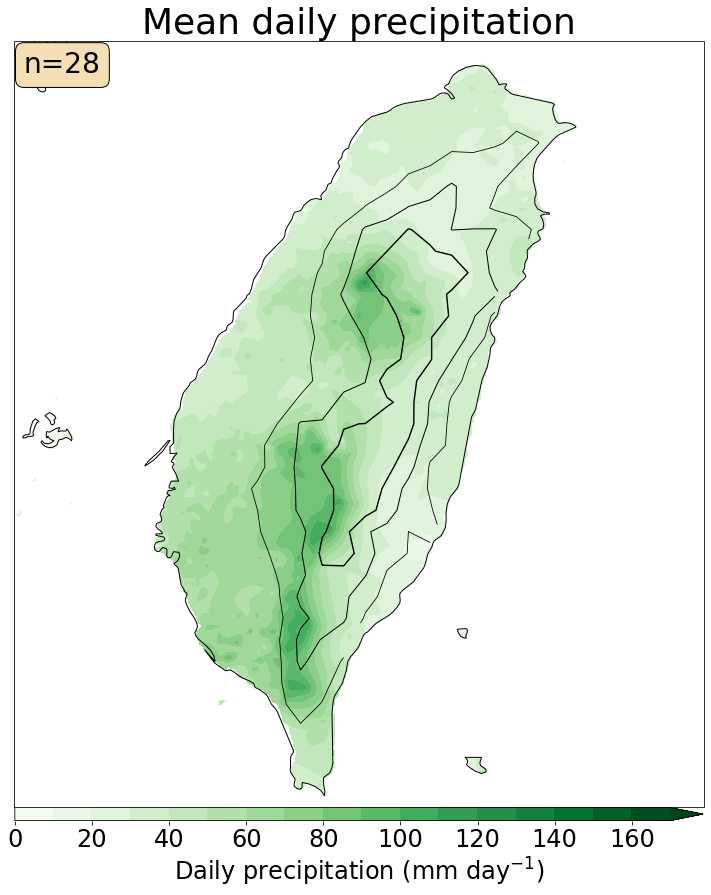

In [112]:
#zipped_t1=list(zip(dates,ar_yesno4))#ar-related = green
#zipped_t2=list(zip(dates,tc_linked_ar_yesno4))
#zipped_t3=list(zip(dates,tc_remnant_linked_ar_yesno4))
#zipped_t4=list(zip(dates,tc_yesno4))#tc-related = blue
#zipped_t5=list(zip(dates,tc_ar_combo_yesno4))
#zipped_t6=list(zip(dates,tc_remnant_ar_combo_yesno4))
#zipped_t7=list(zip(dates,tc_remnants_yesno4))
#zipped_t8=list(zip(dates,ivt_yesno4))#other IVT-related = grey
#zipped_t9=list(zip(dates,tc_linked_ivt_yesno4))
#zipped_t10=list(zip(dates,tc_remnant_linked_ivt_yesno4))
#zipped_t11=list(zip(dates,other_yesno4))#unspecified = brown

fig = plt.figure(figsize=(10,18))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
cax=ax.contourf(p.lon,p.lat,p_mean_other,levels=np.arange(0,180,10),extend='max',cmap=plt.cm.Greens)
cbar=plt.colorbar(cax,pad=0,orientation='horizontal',aspect=50,fraction=0.01086)
dy1=xr.open_dataset(dir2+'etopo1-2.nc')
elevation=dy1['Band1']
X=6
elevation_deres=xr.zeros_like(elevation[0::X,0::X])
elevation_deres['lat']=[x+float(X)/2./111. for x in elevation_deres.lat.values]
elevation_deres['lon']=[x+float(X)/2./102. for x in elevation_deres.lon.values]
for i in range(int(elevation.lat.size/X)):
    for j in range(int(elevation.lon.size/X)):
        elevation_block=elevation[X*i:X*(i+1),X*j:X*(j+1)]
        elevation_mean=elevation_block.mean(dim=('lat','lon')).values
        elevation_deres[i,j]=elevation_mean
elevation_deres=elevation_deres.where(elevation_deres>-200)
ax.contour(elevation_deres.lon,elevation_deres.lat,elevation_deres,levels=[400,1200,2000,2800,3600,4400],colors='k',linewidths=[0.8,1.0,1.4,1.6,1.8,2.0],zorder=20,alpha=1.0)
ax.coastlines(resolution='10m')

if 1==0:
    g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
    cbar.ax.tick_params(labelsize=20) 
    g1.xlabel_style={'size':22,'color':'k'}
    g1.ylabel_style={'size':22,'color':'k'}
    g1.xformatter=LONGITUDE_FORMATTER
    g1.yformatter=LATITUDE_FORMATTER
    g1.xlocator = mticker.FixedLocator([120.5,121.5])
    g1.ylocator = mticker.FixedLocator([21,22,23,24,25,26])

    g1.xlabels_top=False
    g1.ylabels_right=False
ax.set_xlim(119.4,122.6)
ax.set_ylim(21.85,25.4)
cbar.set_label('Daily precipitation (mm day$^{-1}$)',fontsize=24)
cbar.ax.tick_params(labelsize=24)
ax.set_title('Mean daily precipitation',fontsize=36)
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
ax.text(0.015, 0.987,'n='+str(len(dates_other)), transform=ax.transAxes, fontsize=28,verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

In [113]:
fig.savefig(dir+'taiwan_wtype_precip_composites_112.png')#1,2

In [14]:
#@author: Michael Schramm on GitHub
#This function is derived from code originally posted by Sat Kumar Tomer
#(satkumartomer@gmail.com)
#See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
from scipy.stats import norm
import scipy.stats as st
def mk_test(x, alpha=0.05):
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x, tp = np.unique(x, return_counts=True)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

In [ ]:
yrs_taiwan=np.arange(1979,2020,1)
trends=xr.zeros_like(p[0,:,:])
trendsa=xr.zeros_like(p[0,:,:])
slopes=xr.zeros_like(p[0,:,:])
sigs=xr.zeros_like(p[0,:,:])
size=xr.zeros_like(p[0,:,:])


dates=pd.DatetimeIndex(dates_ar)
years=[pd.to_datetime(x).year for x in dates_ar]
p_station=p_station_ar

p_values=xr.zeros_like(p[0,:,:])

for i in range(p.lat.size):
    print(i)
    for j in range(p.lon.size):   
        if p[:,i,j].sum().values>0:
            zipped=list(zip(years,p_station[:,i,j].values.tolist()))
            annual_list=[]
            for k in range(41):
                year=1979+k
                select=[x[1] for x in zipped if x[0]==year]
                select=[x for x in select if x>=0]
                annual_list.append(sum(select))
            nonzero=len([x for x in annual_list if x>0])
            if nonzero<=5:
                size[i,j]=0
            else:
                size[i,j]=1
            mean1=float(sum(annual_list))/float(len(annual_list))
            trend=mk_test(annual_list,alpha=0.05)[0]
            trenda=mk_test(annual_list,alpha=0.1)[0]

            if trend in ['increasing','decreasing']:
                sig=1
            else:
                sig=0
            if trenda in ['increasing','decreasing']:
                siga=1
            else:
                siga=0

            linreg=st.linregress(yrs_taiwan,annual_list)
            trends[i,j]=sig
            trendsa[i,j]=siga
            slopes[i,j]=linreg[0]/mean1*100.
            sigs[i,j]=linreg[3]

            p_values[i,j]=linreg[3]

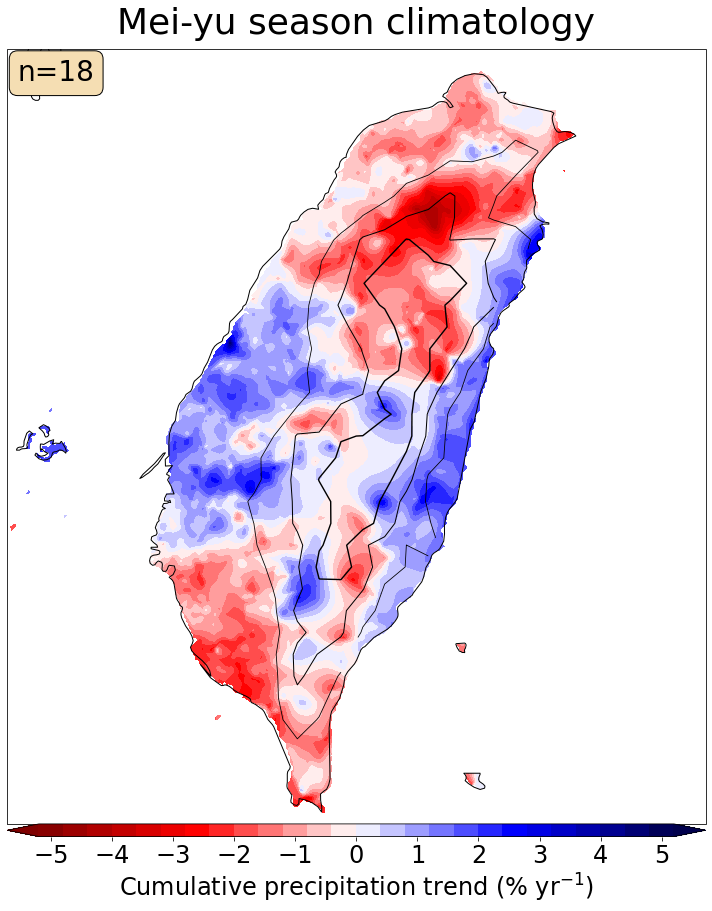

In [131]:
#zipped_t1=list(zip(dates,ar_yesno4))#ar-related = green
#zipped_t2=list(zip(dates,tc_linked_ar_yesno4))
#zipped_t3=list(zip(dates,tc_remnant_linked_ar_yesno4))
#zipped_t4=list(zip(dates,tc_yesno4))#tc-related = blue
#zipped_t5=list(zip(dates,tc_ar_combo_yesno4))
#zipped_t6=list(zip(dates,tc_remnant_ar_combo_yesno4))
#zipped_t7=list(zip(dates,tc_remnants_yesno4))
#zipped_t8=list(zip(dates,ivt_yesno4))#other IVT-related = grey
#zipped_t9=list(zip(dates,tc_linked_ivt_yesno4))
#zipped_t10=list(zip(dates,tc_remnant_linked_ivt_yesno4))
#zipped_t11=list(zip(dates,other_yesno4))#unspecified = brown

p_sum=p.sum(dim='time',skipna=True)
slopes=slopes.where(p_sum>0)


fig = plt.figure(figsize=(10,18))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
cax=ax.contourf(p.lon,p.lat,slopes,levels=np.arange(-5.2,5.6,0.4),extend='both',cmap=plt.cm.seismic_r)
cbar=plt.colorbar(cax,pad=0,orientation='horizontal',aspect=50,ticks=[-5,-4,-3,-2,-1,0,1,2,3,4,5])
dy1=xr.open_dataset(dir2+'etopo1-2.nc')
elevation=dy1['Band1']
X=6
elevation_deres=xr.zeros_like(elevation[0::X,0::X])
elevation_deres['lat']=[x+float(X)/2./111. for x in elevation_deres.lat.values]
elevation_deres['lon']=[x+float(X)/2./102. for x in elevation_deres.lon.values]
for i in range(int(elevation.lat.size/X)):
    for j in range(int(elevation.lon.size/X)):
        elevation_block=elevation[X*i:X*(i+1),X*j:X*(j+1)]
        elevation_mean=elevation_block.mean(dim=('lat','lon')).values
        elevation_deres[i,j]=elevation_mean
elevation_deres=elevation_deres.where(elevation_deres>-200)
ax.contour(elevation_deres.lon,elevation_deres.lat,elevation_deres,levels=[400,1200,2000,2800,3600,4400],colors='k',linewidths=[0.8,1.0,1.4,1.6,1.8,2.0],zorder=20,alpha=1.0)
ax.coastlines(resolution='10m')

Y=4
for i in range(int(p.lat.size/Y)):
    for j in range(int(p.lon.size/Y)):
        mk1=trends[Y*i,Y*j].values
        mk2=trendsa[Y*i,Y*j].values
        slope=slopes[Y*i,Y*j].values
        size1=size[Y*i,Y*j].values
        linsig=p_values[Y*i,Y*j].values
        if 1==1:
            if mk2==1:
                ax.plot(p.lon[int(j*Y)],p.lat[int(i*Y)],marker='o',color='w',markersize=12,mew=1,markerfacecolor='None',zorder=20)
            if mk1==1:
                ax.plot(p.lon[int(j*Y)],p.lat[int(i*Y)],marker='o',color='w',markersize=12,mew=3,markerfacecolor='None',zorder=20)
            if linsig<=0.10 and slope>0:
                ax.plot(p.lon[int(j*Y)],p.lat[int(i*Y)],marker='+',color='w',markersize=12,mew=1,markerfacecolor='None',zorder=20)
            if linsig<=0.05 and slope>0:
                ax.plot(p.lon[int(j*Y)],p.lat[int(i*Y)],marker='+',color='w',markersize=12,mew=3,markerfacecolor='None',zorder=21)
            if linsig<=0.10 and slope<0:
                ax.plot(p.lon[int(j*Y)],p.lat[int(i*Y)],marker='_',color='w',markersize=12,mew=1,markerfacecolor='None',zorder=20)
            if linsig<=0.05 and slope<0:
                ax.plot(p.lon[int(j*Y)],p.lat[int(i*Y)],marker='_',color='w',markersize=12,mew=3,markerfacecolor='None',zorder=21)
            

if 1==0:
    g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
    cbar.ax.tick_params(labelsize=20) 
    g1.xlabel_style={'size':22,'color':'k'}
    g1.ylabel_style={'size':22,'color':'k'}
    g1.xformatter=LONGITUDE_FORMATTER
    g1.yformatter=LATITUDE_FORMATTER
    g1.xlocator = mticker.FixedLocator([120.5,121.5])
    g1.ylocator = mticker.FixedLocator([21,22,23,24,25,26])

    g1.xlabels_top=False
    g1.ylabels_right=False
ax.set_xlim(119.4,122.6)
ax.set_ylim(21.85,25.4)
cbar.set_label('Cumulative precipitation trend (% yr$^{-1}$)',fontsize=24)
cbar.ax.tick_params(labelsize=24)
#ax.set_title('Cumulative precipitation trends',fontsize=36)
ax.set_title('AR-dominant',fontsize=36)
#ax.set_title('Mei-yu season climatology',fontsize=36,pad=15)
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
ax.text(0.015, 0.987,'n='+str(18), transform=ax.transAxes, fontsize=28,verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

In [132]:
fig.savefig(dir+'taiwan_wtype_precip_trend_composites_112.png')#1,2